# Central Alps - Switzerland download

This notebook outputs file `data/AlpsC-ch-slopes.tif`, obtained from SwissTopo APIs.

The bounds requested are Basel-Bard-Trento-Innsbruck
aka `[[[7.734,45.583], [11.249,45.583], [11.249,47.517], [7.734, 47.517], [7.734,45.583]]]`

In [1]:
%load_ext autoreload
%autoreload 2

import os
NBROOT = os.path.realpath(os.curdir)

In [2]:
# Preamble

import logging
logging.basicConfig(level=logging.DEBUG)

from dataclasses import astuple

import os
from os.path import exists, join as pjoin, realpath
from pathlib import Path
from urllib.request import urlopen, urlretrieve

#external
from IPython.display import Image

# import sys
# sys.path.append(os.path.realpath('./src'))
from src import bbox, gdal_slope_util as S

In [3]:
CHC_DTM = 'data/dtm_final/chc_dtm.tif'
dwndir = 'data/chc/dwn'
os.makedirs(dwndir, exist_ok=True)

# Switzerland

We get the data using the awesome *Spatial Temporal Asset Catalog* geodata APIs documented at [geo.admin.ch](http://geo.admin.ch/en/geo-services/geo-services/download-services/stac-api.html) and [data.geo.admin.ch](https://data.geo.admin.ch/api/stac/static/spec/v0.9/api.html#operation/getFeatures)

for documentation:, here's the description of the dataset (`data_desc` below):
```json
{'stac_version': '0.9.0',
   'id': 'ch.swisstopo.swissalti3d',
   'title': 'swissALTI3D',
   'description': 'swissALTI3D is an extremely precise digital elevation model which describes the surface of Switzerland and the Principality of Liechtenstein without vegetation and development. It is updated in an cycle of 6 years.',
   'summaries': {'proj:epsg': [2056], 'eo:gsd': [0.5, 2.0]},
   'extent': {
       'spatial': {'bbox': [[5.950, 45.721, 10.500, 47.821]]},
       'temporal': {'interval': [['2019-01-01T00:00:00Z', '2021-01-01T00:00:00Z']]}},
   'providers': [{
       'name': 'Federal Office of Topography - swisstopo',
       'roles': ['producer', 'licensor'],
       'url': 'https://www.swisstopo.admin.ch'}],
   'license': 'proprietary',
   'created': '2021-02-05T13:54:56.380277Z',
   'updated': '2021-09-20T11:58:15.865192Z',
   'links' : [{'rel': 'self', 'href': '...'}, ...]
}
```


In [4]:
import json
from urllib.parse import urlencode

def apiget(url, **params):
    if params:
        if not url.endswith('?'): url += '?'
        url += urlencode(params) #, quote_via=quote_plus)
    print('GET', url)
    return json.loads(urlopen(url).read())

In [5]:
# Based on this we selct in the full list of URLS downloaded from

# from urllib.parse import urlencode, quote_plus

# params = {
#     'format': 'image/tiff; application=geotiff; profile=cloud-optimized',
#     'resolution': 2,
#     'srid': 2056,
#     'state': 'current',
#     'csv': True
# }
# resp = urlopen(
#         'https://ogd.swisstopo.admin.ch/services/swiseld/services/assets/ch.swisstopo.swissalti3d/search?'
#         + urlencode(params, quote_via=quote_plus)).read()
# import json
# csvurl = json.loads(resp)['href']
# # 'https://ogd.swisstopo.admin.ch/resources/ch.swisstopo.swissalti3d-Mktp9SsL.csv'
# csvcontent = urlopen(csvurl).read()

#2622 1262

In [6]:
# Get all swiss datasets
collections = apiget("https://data.geo.admin.ch/api/stac/v0.9/collections")

GET https://data.geo.admin.ch/api/stac/v0.9/collections


In [7]:
# Helper
def get_first_link(data, rel):
    return [lnk for lnk in data['links'] if lnk['rel'] == rel][0]['href']
# Get the first 100 of features of swissalti3d
data_desc = [c for c in collections['collections'] if c['id'] == 'ch.swisstopo.swissalti3d'][0]
items_link = get_first_link(data_desc, 'items')
items = apiget(items_link, bbox=','.join(map(str,astuple(bbox.bbcalps)))) #, limit=100 == default == max

GET https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissalti3d/items?bbox=7.734%2C45.583%2C11.249%2C47.517


In [8]:
bb_swissalti = bbox.BBox(*data_desc['extent']['spatial']['bbox'][0])
bb_swissalti  # w=5.9503666, s=45.7213375, e=10.4998461, n=47.8216742

BBox(w=5.9503666, s=45.7213375, e=10.4998461, n=47.8216742)

In [9]:
# Explore a sample
sample = items['features'][0]
print(len(items['features']),
    sample['id'],
    sample['bbox'],
    list(sample['assets']),
    sep='\n')

def only_two_meters_tif(feature):
    return [a['href'] for a  in feature['assets'].values() if a['eo:gsd'] == 2 and a['href'].endswith('.tif')]

only_two_meters_tif(sample)

100
swissalti3d_2019_2622-1085
[7.7221803, 45.9162116, 7.7351165, 45.92524]
['swissalti3d_2019_2622-1085_0.5_2056_5728.tif', 'swissalti3d_2019_2622-1085_0.5_2056_5728.xyz.zip', 'swissalti3d_2019_2622-1085_2_2056_5728.tif', 'swissalti3d_2019_2622-1085_2_2056_5728.xyz.zip']


['https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2622-1085/swissalti3d_2019_2622-1085_2_2056_5728.tif']

In [10]:
features = []
while True:
    features += items['features']
    if len(features) % 10000 == 0:
        print(len(features))
    try:
        items = apiget(get_first_link(items, 'next'))
    except IndexError:
        break
# Takes ~200 seconds & iterations
print(len(features))  #26064

GET https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissalti3d/items?bbox=7.734%2C45.583%2C11.249%2C47.517&cursor=cD1zd2lzc2FsdGkzZF8yMDE5XzI2MjItMTE4NA%3D%3D
GET https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissalti3d/items?bbox=7.734%2C45.583%2C11.249%2C47.517&cursor=cD1zd2lzc2FsdGkzZF8yMDE5XzI2MjMtMTEwNg%3D%3D
GET https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissalti3d/items?bbox=7.734%2C45.583%2C11.249%2C47.517&cursor=cD1zd2lzc2FsdGkzZF8yMDE5XzI2MjMtMTIwNg%3D%3D
GET https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissalti3d/items?bbox=7.734%2C45.583%2C11.249%2C47.517&cursor=cD1zd2lzc2FsdGkzZF8yMDE5XzI2MjQtMTEzMA%3D%3D
GET https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissalti3d/items?bbox=7.734%2C45.583%2C11.249%2C47.517&cursor=cD1zd2lzc2FsdGkzZF8yMDE5XzI2MjQtMTIzMA%3D%3D
GET https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissalti3d/items?bbox=7.734%2C45.583%2C11.249

In [11]:
# check file integruty with:
# !for f in dwn/swissalti3d_*.tif ; do gdalinfo $f >/dev/null ; done

# dwn/swissalti3d_2019_2650-1221_2_2056_5728.tif

In [12]:
urls = [url
    for feat in features
    for url in only_two_meters_tif(feat)
] #if Bbox(*feat['bbox']).intersect(bbcalps)]  # <- covered by the bbox parameter
len(urls)

26064

In [13]:
urls[0], urls[1]

('https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2622-1085/swissalti3d_2019_2622-1085_2_2056_5728.tif',
 'https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2622-1086/swissalti3d_2019_2622-1086_2_2056_5728.tif')

In [14]:
for cururl in urls:
    destpath = '/'.join((dwndir, cururl.split('/')[-1]))
    if not os.path.exists(destpath):
        urlretrieve(cururl, destpath)

# follow download of 26064 files in eslope/development/data/ch/
# at around 3 files/second it takes >2h
# feel free to symlink in case of disk space issue

In [15]:
! ls -1 $dwndir | wc -l

26064


In [16]:
# print('''{
#   "type": "FeatureCollection",
#   "features": [''')
# for bb in (bbcalps, *(Bbox(*feat['bbox']) for feat in items['features'])):
#     print('''    {   "type": "Feature",
#         "geometry": { "type": "LineString",
#             "coordinates": [ [%s, %s], [%s, %s] ] },
#         "properties": {}
#     },''' % (bb.w, bb.s, bb.e, bb.n))
# print(''']}''')

In [17]:
bb = bb_swissalti.intersection(bbox.bbcalps)
print(bb_swissalti, bbox.bbcalps, bb, sep='\n')

5.9503666 45.7213375 10.4998461 47.8216742
7.734 45.583 11.249 47.517
7.734 45.7213375 10.4998461 47.517


In [18]:
!echo "7.734 45.721\n10.500 47.517" | gdaltransform -s_srs EPSG:4326 -t_srs EPSG:2056

2622998.64917026 1063298.09713657 0
2830535.57296033 1267415.86684333 0


In [19]:
%cd data/chc
# basenames = [url.split('/')[-1] + '\n' for url in urls]
basenames = [str(p) + '\n' for p in Path('dwn').glob('swissalti3d_*.tif')]
vrtpieces = 'vrt_input_files.txt'
vrt = 'chc-dtm.vrt'
with open(vrtpieces, 'w') as f:
    f.writelines(basenames)
!wc -l $vrtpieces

!gdalbuildvrt -overwrite\
    -input_file_list $vrtpieces $vrt
# -te 2622998 1063298 2830535 1267476 -tr 2 2 -a_srs EPSG:2056 \

%cd $NBROOT

/home/me/code/eddy-geek/slope-ign-alti/chc
26064 vrt_input_files.txt
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/me/code/eddy-geek/eslope/development


⚠️ Generated file is 103763 x 102040 and 17 GB (Valais was 69500 x 40000 and 5 GB).

In [31]:
if not exists(CHC_DTM):
    cmd = f'''
        gdalwarp {S.DFLT_WARP_OPT}\\
            -dstnodata -9999 -te_srs WGS84 -te {str(bb)}  \\
            data/chc/{vrt} {CHC_DTM}
    '''
    print(cmd)
    S.check_run(cmd)


        gdalwarp -co COMPRESS=ZSTD -co PREDICTOR=2 -co ZSTD_LEVEL=1 -co TILED=YES -co blockXsize=1024 -co blockYsize=1024 -co BIGTIFF=YES -co SPARSE_OK=TRUE -co NUM_THREADS=ALL_CPUS -multi -wo NUM_THREADS=ALL_CPUS -overwrite \
            -dstnodata -9999 -te_srs WGS84 -te 7.734 45.7213375 10.4998461 47.517  \
            data/chc/chc-dtm.vrt data/dtm_final/chc_dtm.tif
    
Creating output file that is 103763P x 102040L.
Processing data/chc/chc-dtm.vrt [1/1] : 0Using internal nodata values (e.g. -9999) for image data/chc/chc-dtm.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.


In [32]:
!gdalinfo $CHC_DTM | rg -v '\['

Driver: GTiff/GeoTIFF
Files: data/dtm_final/chc_dtm.tif
       data/dtm_final/chc_dtm.tif.aux.xml
Size is 103763, 102040
Coordinate System is:
Data axis to CRS axis mapping: 1,2
Origin = (2622998.508232237305492,1267415.414544902043417)
Pixel Size = (1.999995000095153,-1.999998010785012)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=ZSTD
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( 2622998.508, 1267415.415) (  7d44'42.69"E, 47d33'30.40"N)
Lower Left  ( 2622998.508, 1063335.618) (  7d44' 5.91"E, 45d43'21.04"N)
Upper Right ( 2830523.989, 1267415.415) ( 10d30' 4.61"E, 47d31' 6.09"N)
Lower Right ( 2830523.989, 1063335.618) ( 10d23'56.53"E, 45d41' 1.50"N)
Center      ( 2726761.249, 1165375.516) (  9d 5'42.50"E, 46d37'43.92"N)
Band 1 Block=1024x1024 Type=Float32, ColorInterp=Gray
  Min=3857.896 Max=3898.859 
  Minimum=3857.896, Maximum=3898.859, Mean=3877.632, StdDev=14.227
  NoData Value=-9999
  Metadata:
    STATISTICS_MAXIMUM=3898.8591308594
    STATISTICS_

In [4]:
res = 400
ram_opt = '--config GDAL_CACHEMAX 512 -wm 1024'  # in MB
S.check_run(f'gdalwarp {ram_opt} -overwrite -ot Byte -tr {res} {-res} {CHC_DTM} chc_dtm_ovr.png')
# 2 minutes and 5 GB RAM :-(

Creating output file that is 519P x 510L.
Using internal nodata values (e.g. -9999) for image data/dtm_final/chc_dtm.tif.
Copying nodata values from source data/dtm_final/chc_dtm.tif to destination .
0...10...20...30...40...50...60...70...80...90...100 - done.


0

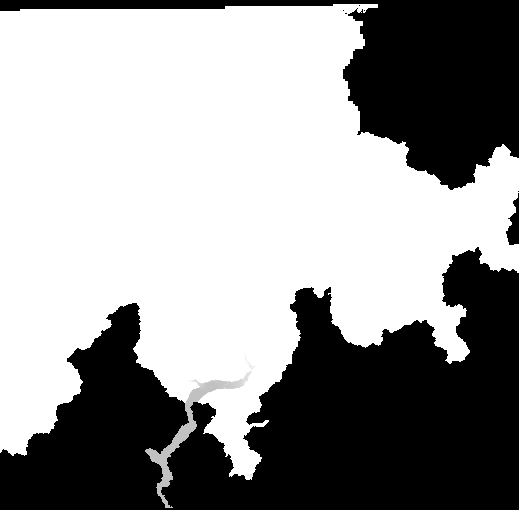

In [5]:
# If there are holes, go back to the top :)
Image('chc_dtm_ovr.png')